In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sqlalchemy import Table, create_engine
from config import db_password

import psycopg2

import hvplot.pandas
from path import Path
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

In [10]:
combo_df = pd.read_csv("../Resources/cleaned_df_for_MI.csv")
combo_df.columns.tolist()

['Rank',
 'Name',
 'Platform',
 'Genre',
 'Publisher',
 'NA_Sales',
 'EU_Sales',
 'JP_Sales',
 'Other_Sales',
 'Global_Sales',
 'metascore',
 'user_score',
 'release_date',
 'positive_critics',
 'neutral_critics',
 'negative_critics',
 'positive_users',
 'neutral_users',
 'negative_users',
 'developer',
 'number_players',
 'rating',
 'is_handheld',
 'is_deprecated',
 'is_retro',
 'year',
 'month']

In [11]:
# Dropping the useless "Rank" column
combo_df.drop(columns=["Rank"], axis=1, inplace=True)

In [12]:
# Many userscores are missing because there simply havent been any user ratings on 
# metacritic yet. Similarly, some games don't have metascores.
combo_df.isnull().sum()

Name                   0
Platform               0
Genre                  0
Publisher              4
NA_Sales               0
EU_Sales               0
JP_Sales               0
Other_Sales            0
Global_Sales           0
metascore           1013
user_score           923
release_date           0
positive_critics       0
neutral_critics        0
negative_critics       0
positive_users         0
neutral_users          0
negative_users         0
developer           7392
number_players         0
rating                 0
is_handheld            0
is_deprecated          0
is_retro               0
year                   0
month                  0
dtype: int64

In [13]:
# The ratings EC and K-A stand for "Early Childhood" and "Kids-Adults" respectively. 
# For our purposes, this means these categories can be bunched within the E 
# category. There are too few cases of each, and I don't want it to throw the model off, 
# because realistically this shouldn't make a difference.
# Similarly, I will be lumping the one "AO" for "Adult" rating in with mature. 
combo_df["rating"].value_counts()
combo_df["rating"] = combo_df["rating"].map(lambda rating: "E" if rating in ("EC","K-A")\
                                            else("M" if rating =="AO" else rating))



In [14]:
combo_df.dtypes

Name                 object
Platform             object
Genre                object
Publisher            object
NA_Sales            float64
EU_Sales            float64
JP_Sales            float64
Other_Sales         float64
Global_Sales        float64
metascore           float64
user_score          float64
release_date         object
positive_critics      int64
neutral_critics       int64
negative_critics      int64
positive_users        int64
neutral_users         int64
negative_users        int64
developer           float64
number_players       object
rating               object
is_handheld          object
is_deprecated        object
is_retro             object
year                  int64
month                 int64
dtype: object

In [15]:
# There are 231 distinct categories of publisher.
publisher_counts = combo_df["Publisher"].value_counts()
publisher_counts

Electronic Arts                935
Activision                     628
Ubisoft                        544
THQ                            473
Sony Computer Entertainment    351
                              ... 
FuRyu                            1
Liquid Games                     1
Big Ben Interactive              1
Insomniac Games                  1
Ocean                            1
Name: Publisher, Length: 231, dtype: int64

In [16]:
developer_counts = combo_df["developer"].value_counts()
developer_counts

Series([], Name: developer, dtype: int64)

In [17]:
# There are too many unique values for both publisher and developer to use one-hot-encoding on
# which the deep neural network will require. Therefore I need to do some binning.

(-250.0, 500.0)

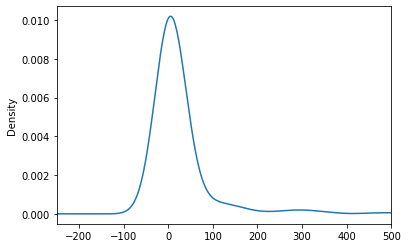

In [18]:
publisher_counts.plot.density()
plt.xlim(-250, 500)

(-20.0, 200.0)

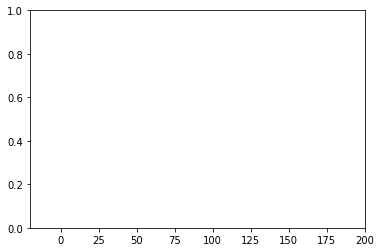

In [19]:
#developer_counts.plot.density()
plt.xlim(-20,200)

In [20]:
# There is an exceptionally large amount of categories in this data that is perhaps not justified in
# a deep learning model. 
publishers_to_change = publisher_counts[publisher_counts<100].index

for publisher in publishers_to_change:
    combo_df["Publisher"] = combo_df["Publisher"].replace(publisher, "Other")

combo_df["Publisher"].value_counts()

Other                                     1575
Electronic Arts                            935
Activision                                 628
Ubisoft                                    544
THQ                                        473
Sony Computer Entertainment                351
Konami Digital Entertainment               318
Nintendo                                   306
Sega                                       277
Take-Two Interactive                       277
Namco Bandai Games                         237
Capcom                                     175
Atari                                      174
Warner Bros. Interactive Entertainment     146
Midway Games                               142
Disney Interactive Studios                 140
Tecmo Koei                                 138
Square Enix                                115
Vivendi Games                              114
Eidos Interactive                          114
Microsoft Game Studios                     105
505 Games    

In [21]:
# There are also way too many unique instances of developers, even after binning. I may leave this out as well. 
# Regardless, it is not likley that the Developer would have an overwhelming influence on sales.
developers_to_change = developer_counts[developer_counts<45].index

for developer in developers_to_change:
    combo_df["developer"] = combo_df["developer"].replace(developer, "Other")

combo_df["developer"].value_counts()

Series([], Name: developer, dtype: int64)

## Is there a way to break down developers and publishers in a meaningful way other than number of value counts? Perhaps by where the developer or publisher is from? Japan, North America, Europe, etc. It would give us a good metric of where the best games come from and if that is meaningful then for predicting its success. Will have to go look manually however.., or create a scraping script. Probably not feasable or time efficient.

In [22]:
# I need to make sure I know the ratings before I convert them to numbers for use in unsupervised learning clustering.
combo_df["rating"].unique()

array(['E', 'M', 'T', 'E10+'], dtype=object)

In [23]:
combo_df["rating"].head(30)

0     E
1     E
2     E
3     E
4     E
5     E
6     E
7     E
8     E
9     E
10    M
11    M
12    E
13    M
14    M
15    E
16    E
17    M
18    M
19    M
20    M
21    M
22    M
23    M
24    T
25    M
26    E
27    M
28    M
29    E
Name: rating, dtype: object

In [24]:
combo_df["Genre"].value_counts()

Action          1712
Sports          1215
Shooter          715
Misc             660
Racing           660
Role-Playing     587
Platform         491
Fighting         393
Simulation       314
Adventure        299
Puzzle           180
Strategy         166
Name: Genre, dtype: int64

In [25]:
# dropping developer and publisher columns for now as they are likely not going to be a strong predictor of sales.
combo_df.drop(columns=["Publisher", "developer"], inplace=True)

In [26]:
# There are many null metacritic and user_score values.
combo_df.isnull().sum()

Name                   0
Platform               0
Genre                  0
NA_Sales               0
EU_Sales               0
JP_Sales               0
Other_Sales            0
Global_Sales           0
metascore           1013
user_score           923
release_date           0
positive_critics       0
neutral_critics        0
negative_critics       0
positive_users         0
neutral_users          0
negative_users         0
number_players         0
rating                 0
is_handheld            0
is_deprecated          0
is_retro               0
year                   0
month                  0
dtype: int64

## Time to begin preprocessing of the data to run it through unsupervised as well as supervised learning algorithms. Preprocessing will be different depending on which we are doing. 

In [27]:
### First however, we are going to use random forests to fill in mising data in our metacritic column.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Creating a copy of the combo_df
combo_df2 = combo_df.copy()

# Instantiate an instance of the LabelEncoder
le =LabelEncoder()

#Encode the labels
combo_df2["Platform1"] = le.fit_transform(combo_df2["Platform"])
combo_df2["Genre"] = le.fit_transform(combo_df2["Genre"])
combo_df2["rating"] = le.fit_transform(combo_df2["rating"])
combo_df2= pd.get_dummies(data=combo_df2, columns=["is_handheld","is_deprecated","is_retro"],drop_first=True)



In [28]:
# Drop non-encoded features
combo_df2.drop(columns=["month","release_date","number_players","year"],inplace=True)
combo_df2

,Name,Platform,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,metascore,user_score,...,neutral_critics,negative_critics,positive_users,neutral_users,negative_users,rating,Platform1,is_handheld_yes,is_deprecated_yes,is_retro_yes
0,Wii Sports,Wii,10,41.49,29.02,3.77,8.46,82.74,76.0,8.0,...,20,0,105,40,3,0,11,0,1,0
1,Mario Kart Wii,Wii,6,15.85,12.88,3.79,3.31,35.82,82.0,8.4,...,7,1,235,62,22,0,11,0,1,0
2,Wii Sports Resort,Wii,10,15.75,11.01,3.28,2.96,33.00,80.0,8.1,...,13,0,62,15,4,0,11,0,1,0
3,New Super Mario Bros.,DS,4,11.38,9.23,6.50,2.90,30.01,89.0,8.5,...,3,0,137,28,2,0,1,1,1,1
4,Wii Play,Wii,3,14.03,9.20,2.93,2.85,29.02,58.0,6.5,...,31,8,32,27,15,0,11,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7387,Scurge: Hive,DS,0,0.05,0.00,0.00,0.00,0.06,70.0,7.4,...,14,2,0,1,0,1,1,1,1,1
7388,Catwoman,XB,0,0.04,0.01,0.00,0.00,0.06,45.0,4.2,...,11,21,0,1,2,3,14,0,1,1
7389,Aquarium by DS,DS,9,0.05,0.00,0.00,0.00,0.06,NaN,NaN,...,0,1,0,1,0,0,1,1,1,1
7390,Ride to Hell,X360,6,0.04,0.01,0.00,0.00,0.06,19.0,1.3,...,0,14,19,3,92,2,13,0,1,0


In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Instantiate an instance of the Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=128)

# Creating a training and testing set. The testing set will consist of all rows with null metascore columns
train_set = combo_df2[combo_df2["metascore"].notnull()]
test_set = combo_df2[~combo_df2["metascore"].notnull()]

#  Split the training set
X_train = train_set.drop(columns=["metascore","user_score","Name", "Platform"])
y_train = train_set["metascore"]

# Instantiate the standardscaler object
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# fit the randomforestregressor
rfr.fit(X_train_scaled, y_train)

# Split the testing set
X_test = test_set.drop(columns=["metascore","user_score","Name", "Platform"])
X_test_scaled = scaler.transform(X_test)

# make predictions off of the testing set.
predictions = rfr.predict(X_test_scaled)
predictions = pd.Series(np.round(predictions))

In [30]:
test_set.reset_index(drop=True,inplace=True)

fixed_set = pd.concat([test_set, predictions], axis=1)

In [31]:
fixed_set["metascore"]=fixed_set[0]

In [32]:
fixed_set.drop(0,axis=1,inplace=True)

In [33]:
fixed_set[["Name","Platform","metascore"]]

,Name,Platform,metascore
0,Zumba Fitness,Wii,63.0
1,FIFA 15,PS3,68.0
2,Call of Duty: Advanced Warfare,PS3,64.0
3,Call of Duty: Advanced Warfare,X360,64.0
4,World Soccer Winning Eleven 9,PS2,85.0
...,...,...,...
1008,Gem Smashers,Wii,63.0
1009,Call of Duty: The War Collection,X360,63.0
1010,Syphon Filter: Logan's Shadow,PS2,60.0
1011,Pucca Power Up,DS,61.0


In [34]:


to_fill = combo_df[combo_df["metascore"].isnull()]

to_fill.reset_index(drop=True, inplace=True)

to_fill

filled = pd.concat([to_fill, predictions],axis=1)
filled.drop("metascore",axis=1, inplace=True)
filled = filled.rename({0:"metascore"},axis=1)
filled

to_fill

,Name,Platform,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,metascore,user_score,...,positive_users,neutral_users,negative_users,number_players,rating,is_handheld,is_deprecated,is_retro,year,month
0,Zumba Fitness,Wii,Sports,3.50,2.64,0.00,0.67,6.81,NaN,5.6,...,0,1,0,local multiplayer,E,no,yes,no,2010,11
1,FIFA 15,PS3,Sports,0.57,3.14,0.04,1.07,4.82,NaN,4.6,...,2,7,15,local multiplayer,E,no,yes,no,2014,9
2,Call of Duty: Advanced Warfare,PS3,Shooter,1.54,1.94,0.19,0.77,4.45,NaN,5.0,...,19,22,14,Online Multiplayer,M,no,yes,no,2014,11
3,Call of Duty: Advanced Warfare,X360,Shooter,2.75,1.18,0.00,0.37,4.31,NaN,5.0,...,25,8,19,ambiguous,M,no,yes,no,2014,11
4,World Soccer Winning Eleven 9,PS2,Sports,0.12,2.26,0.90,0.77,4.06,NaN,8.2,...,9,0,1,Online Multiplayer,E,no,yes,yes,2006,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,Gem Smashers,Wii,Platform,0.05,0.00,0.00,0.00,0.06,NaN,NaN,...,0,0,0,ambiguous,E,no,yes,no,2011,11
1009,Call of Duty: The War Collection,X360,Shooter,0.05,0.00,0.00,0.00,0.06,NaN,NaN,...,0,0,0,Online Multiplayer,M,no,yes,no,2010,6
1010,Syphon Filter: Logan's Shadow,PS2,Shooter,0.03,0.02,0.00,0.01,0.06,NaN,8.0,...,0,0,0,Online Multiplayer,T,no,yes,yes,2010,6
1011,Pucca Power Up,DS,Platform,0.04,0.02,0.00,0.00,0.06,NaN,NaN,...,1,0,0,No Online Multiplayer,E,yes,yes,yes,2011,9


In [35]:
filled.columns
filled = filled[['Name', 'Platform', 'Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales',
       'Other_Sales', 'Global_Sales', 'metascore','user_score', 'release_date',
       'positive_critics', 'neutral_critics', 'negative_critics',
       'positive_users', 'neutral_users', 'negative_users', 'number_players',
       'rating', 'is_handheld', 'is_deprecated', 'is_retro', 'year', 'month']]

In [36]:
filled.isnull().sum()

Name                  0
Platform              0
Genre                 0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
metascore             0
user_score          457
release_date          0
positive_critics      0
neutral_critics       0
negative_critics      0
positive_users        0
neutral_users         0
negative_users        0
number_players        0
rating                0
is_handheld           0
is_deprecated         0
is_retro              0
year                  0
month                 0
dtype: int64

In [37]:
combo_df.dropna(inplace=True)

In [38]:
# I successfully used randomforests to fill in missing values for metascore 

combo_df = pd.concat([combo_df, filled],axis=0)
combo_df

,Name,Platform,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,metascore,user_score,...,positive_users,neutral_users,negative_users,number_players,rating,is_handheld,is_deprecated,is_retro,year,month
0,Wii Sports,Wii,Sports,41.49,29.02,3.77,8.46,82.74,76.0,8.0,...,105,40,3,No Online Multiplayer,E,no,yes,no,2006,11
1,Mario Kart Wii,Wii,Racing,15.85,12.88,3.79,3.31,35.82,82.0,8.4,...,235,62,22,Online Multiplayer,E,no,yes,no,2008,4
2,Wii Sports Resort,Wii,Sports,15.75,11.01,3.28,2.96,33.00,80.0,8.1,...,62,15,4,local multiplayer,E,no,yes,no,2009,7
3,New Super Mario Bros.,DS,Platform,11.38,9.23,6.50,2.90,30.01,89.0,8.5,...,137,28,2,No Online Multiplayer,E,yes,yes,yes,2006,5
4,Wii Play,Wii,Misc,14.03,9.20,2.93,2.85,29.02,58.0,6.5,...,32,27,15,No Online Multiplayer,E,no,yes,no,2007,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,Gem Smashers,Wii,Platform,0.05,0.00,0.00,0.00,0.06,63.0,NaN,...,0,0,0,ambiguous,E,no,yes,no,2011,11
1009,Call of Duty: The War Collection,X360,Shooter,0.05,0.00,0.00,0.00,0.06,63.0,NaN,...,0,0,0,Online Multiplayer,M,no,yes,no,2010,6
1010,Syphon Filter: Logan's Shadow,PS2,Shooter,0.03,0.02,0.00,0.01,0.06,60.0,8.0,...,0,0,0,Online Multiplayer,T,no,yes,yes,2010,6
1011,Pucca Power Up,DS,Platform,0.04,0.02,0.00,0.00,0.06,61.0,NaN,...,1,0,0,No Online Multiplayer,E,yes,yes,yes,2011,9


In [39]:
combo_df.isnull().sum()

Name                  0
Platform              0
Genre                 0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
metascore             0
user_score          457
release_date          0
positive_critics      0
neutral_critics       0
negative_critics      0
positive_users        0
neutral_users         0
negative_users        0
number_players        0
rating                0
is_handheld           0
is_deprecated         0
is_retro              0
year                  0
month                 0
dtype: int64

In [40]:
# I will drop the remaining columns for the sake of time.
combo_df.dropna(inplace=True)
combo_df.isnull().sum()

Name                0
Platform            0
Genre               0
NA_Sales            0
EU_Sales            0
JP_Sales            0
Other_Sales         0
Global_Sales        0
metascore           0
user_score          0
release_date        0
positive_critics    0
neutral_critics     0
negative_critics    0
positive_users      0
neutral_users       0
negative_users      0
number_players      0
rating              0
is_handheld         0
is_deprecated       0
is_retro            0
year                0
month               0
dtype: int64

In [41]:
combo_df.iloc[:5,5:]

,JP_Sales,Other_Sales,Global_Sales,metascore,user_score,release_date,positive_critics,neutral_critics,negative_critics,positive_users,neutral_users,negative_users,number_players,rating,is_handheld,is_deprecated,is_retro,year,month
0,3.77,8.46,82.74,76.0,8.0,2006-11-19,31,20,0,105,40,3,No Online Multiplayer,E,no,yes,no,2006,11
1,3.79,3.31,35.82,82.0,8.4,2008-04-27,65,7,1,235,62,22,Online Multiplayer,E,no,yes,no,2008,4
2,3.28,2.96,33.00,80.0,8.1,2009-07-26,60,13,0,62,15,4,local multiplayer,E,no,yes,no,2009,7
3,6.50,2.90,30.01,89.0,8.5,2006-05-15,62,3,0,137,28,2,No Online Multiplayer,E,yes,yes,yes,2006,5
4,2.93,2.85,29.02,58.0,6.5,2007-02-12,2,31,8,32,27,15,No Online Multiplayer,E,no,yes,no,2007,2


In [42]:
combo_df.head()

,Name,Platform,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,metascore,user_score,...,positive_users,neutral_users,negative_users,number_players,rating,is_handheld,is_deprecated,is_retro,year,month
0,Wii Sports,Wii,Sports,41.49,29.02,3.77,8.46,82.74,76.0,8.0,...,105,40,3,No Online Multiplayer,E,no,yes,no,2006,11
1,Mario Kart Wii,Wii,Racing,15.85,12.88,3.79,3.31,35.82,82.0,8.4,...,235,62,22,Online Multiplayer,E,no,yes,no,2008,4
2,Wii Sports Resort,Wii,Sports,15.75,11.01,3.28,2.96,33.00,80.0,8.1,...,62,15,4,local multiplayer,E,no,yes,no,2009,7
3,New Super Mario Bros.,DS,Platform,11.38,9.23,6.50,2.90,30.01,89.0,8.5,...,137,28,2,No Online Multiplayer,E,yes,yes,yes,2006,5
4,Wii Play,Wii,Misc,14.03,9.20,2.93,2.85,29.02,58.0,6.5,...,32,27,15,No Online Multiplayer,E,no,yes,no,2007,2


In [43]:
# Explore the data using unsupervised learning.

In [44]:
# Use label encoder to process the data for clustering. This is so that different categories are represented within
# a single column per feature.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [45]:
le = LabelEncoder()

combo_df["Genre"] = le.fit_transform(combo_df["Genre"])
combo_df["is_handheld"] = le.fit_transform(combo_df["is_handheld"])

In [46]:
combo_df.sort_values("NA_Sales", ascending=False)
# Getting rid of an outlier
combo_df.drop(0,inplace=True)

In [47]:
combo_df.reset_index(drop=True, inplace=True)

In [48]:
combo_df["rating"] = le.fit_transform(combo_df["rating"])

In [49]:
# I want to run several different data inputs through my clustering algorithm.  will mkae the subsets here.
data1 = combo_df[["user_score","metascore","NA_Sales"]]
data2 = combo_df[["is_handheld","rating","NA_Sales"]]
data3 = combo_df[["rating","metascore","NA_Sales"]]
data4 = combo_df[["NA_Sales", "JP_Sales", "Genre"]]

In [50]:
combo_df["rating"].unique()
# 0:E, 1:E10+, 2:M, 3:T

array([0, 2, 3, 1])

In [51]:
data2["rating"].head(30)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     2
10    2
11    0
12    2
13    2
14    0
15    0
16    2
17    2
18    2
19    2
20    2
21    2
22    2
23    3
24    2
25    0
26    2
27    2
28    0
29    0
Name: rating, dtype: int64

In [52]:
data1.iloc[:,0]

0       8.4
1       8.1
2       8.5
3       6.5
4       8.3
       ... 
6462    4.0
6463    7.9
6464    6.5
6465    7.6
6466    8.0
Name: user_score, Length: 6467, dtype: float64

In [53]:
data1.columns[0]

'user_score'

In [59]:
# Use Object-Oriented Programming to create the backbone of the models for use with different feature subsets.
from Clustering_Class_Module import GraphKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [60]:
user_meta_na = GraphKMeans(data1)

In [61]:
user_meta_na.scale_data()

In [62]:
user_meta_na.elbow_curve()

:Curve   [k]   (inertia)

In [77]:
user_meta_na.cluster_data(4)

# There is a weak correlation with sales and metacritic scores and user_scores with reflect each other closely
# There appears to be a consistent increase in sales for games with a metascore above 60. Increase in Sales is 
# more pronounced for increases in metascore than increases in user_score. In short, the positive correlation 
# between metascore and Sales is stronger than that between user_score and sales, which is what we would expect
# if you trust the critics to be a reflection of the market success a game will have. The number of games that 
# hit it big (outliers) increase with each different cluster.

In [78]:
handheld_rating_na = GraphKMeans(data2)
handheld_rating_na.scale_data()
handheld_rating_na.elbow_curve()

:Curve   [k]   (inertia)

In [79]:
# We will choose 4 as k
handheld_rating_na.cluster_data(4)

# Ratings Key:
# 0: E, 1: E10+, 2: M, 3: T
# handheld games tend to have lower sales. 
# This shows that games in North America with a rating of E, the games most available to everyone, have the highest
# Sales. M rated games have the next highest sales, and then Teen games and then E10+

# However, this klustering shows that clustering by whether a game is handheld or not doesn't really give us
# any new meaningful information.

In [80]:
rating_meta_na = GraphKMeans(data3)
rating_meta_na.scale_data()
rating_meta_na.elbow_curve()

:Curve   [k]   (inertia)

In [81]:
rating_meta_na.cluster_data(k=4)

In [82]:
# Do JP_Sales, NA_Sales, genre
na_jp_genre = GraphKMeans(data4)
na_jp_genre.scale_data()
na_jp_genre.elbow_curve()

:Curve   [k]   (inertia)

In [83]:
na_jp_genre.cluster_data(6)

# Attempt to predict Sales using a deep neural network

### Features to fiddle with:
### * grouping of multiplayer classes
### * including the platform columns
### * with and without multiple imputation

### I am choosing a neural network, because they are adept at picking up suttle correlations between combinations of features and 
### the label. Our data is attempting to predict a label off of features that appear only loosing correlated with Sales.
### My hope is that the deep learning model can pick up suttle patterns from all this review data along with our other
### features to make accurate predictions about sales.

In [84]:
# Getting dummies for features with more than two categories.
# consider taking out "Platform" later for better model results
deep_learning_df = pd.get_dummies(data=combo_df, columns=["Platform","Genre","number_players","rating","year","month"])

# Getting dummy variables with only two categories and dropping the first one. I did these 
# separately so that I could use the drop_first argument so the two columns are not perfectly
# correlated.
deep_learning_df = pd.get_dummies(data=deep_learning_df, columns=["is_handheld","is_deprecated","is_retro"], drop_first=True)

# Drop remaining non-numeric columns

deep_learning_df.drop(["Name","release_date"],axis=1, inplace=True)

In [85]:
deep_learning_df

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,metascore,user_score,positive_critics,neutral_critics,negative_critics,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,is_handheld_1,is_deprecated_yes,is_retro_yes
0,15.85,12.88,3.79,3.31,35.82,82.0,8.4,65,7,1,...,0,0,0,0,0,0,0,0,1,0
1,15.75,11.01,3.28,2.96,33.00,80.0,8.1,60,13,0,...,0,1,0,0,0,0,0,0,1,0
2,11.38,9.23,6.50,2.90,30.01,89.0,8.5,62,3,0,...,0,0,0,0,0,0,0,1,1,1
3,14.03,9.20,2.93,2.85,29.02,58.0,6.5,2,31,8,...,0,0,0,0,0,0,0,0,1,0
4,14.59,7.06,4.70,2.26,28.62,87.0,8.3,75,5,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6462,0.06,0.00,0.00,0.00,0.06,60.0,4.0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
6463,0.00,0.00,0.06,0.00,0.06,68.0,7.9,1,1,0,...,1,0,0,0,0,0,0,1,1,1
6464,0.06,0.00,0.00,0.00,0.06,63.0,6.5,0,0,0,...,0,0,0,0,1,0,0,0,1,0
6465,0.00,0.00,0.06,0.00,0.06,66.0,7.6,1,1,0,...,0,0,0,0,1,0,0,1,1,1


In [86]:
X = deep_learning_df.drop(["NA_Sales", "JP_Sales","Global_Sales","Other_Sales","EU_Sales"],axis=1).values
y = deep_learning_df[["NA_Sales","JP_Sales","EU_Sales","Other_Sales","Global_Sales"]].values

In [87]:
X.shape

(6467, 83)

In [88]:
y.shape

(6467, 5)

In [89]:
# Import the module with a class for Deep Learning models.
from Keras_Class_Module import DeepLearning

In [90]:
model_one = DeepLearning(X,y,"multi",hidden_layers=4,input_dim=83)
model_one.model_split()
model_one.make_model()
model_one.compile_model()
model_one.fit_model()


Epoch 1/600
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/142 [====================>.........] - ETA: 0s - loss: 0.7443 - mse: 0.7443WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe941f17b00> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and at

In [91]:
model_one.evaluate_model()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
NA RMSE: 0.8705


NA MSE: 0.7578


NA MAE: 0.3263


The mean sales of NA for this dataset is 0.4364


EU RMSE: 0.3502


EU MSE: 0.1227


EU MAE: 0.1016


The mean sales of EU for this dataset is 0.0676


JP RMSE: 0.6140


JP MSE: 0.3771


JP MAE: 0.2197


The mean sales of JP for this dataset is 0.2478


Other RMSE: 0.2563


Other MSE: 0.0657


Other MAE: 0.0775


The mean sa

In [92]:
deep_learning_df.describe()

# This shows that my models mean absolute error is over half the size of the mean value of sales for NA itself. This 
# is not good. 

# Also of note is how bad the mean squared error is. Mean squared errors punish particularly bad outliers. This is
# what I would expect given the extremely skewed nature of the dataset. 
# In summary, the data has too many outliers to make accuracte predictions

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,metascore,user_score,positive_critics,neutral_critics,negative_critics,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,is_handheld_1,is_deprecated_yes,is_retro_yes
count,6467.000000,6467.000000,6467.000000,6467.000000,6467.000000,6467.000000,6467.000000,6467.000000,6467.000000,6467.000000,...,6467.000000,6467.000000,6467.000000,6467.000000,6467.000000,6467.000000,6467.000000,6467.000000,6467.000000,6467.000000
mean,0.436391,0.247810,0.067552,0.091486,0.843269,69.152776,7.160275,15.285758,9.157724,2.006185,...,0.077316,0.036957,0.062007,0.125870,0.177207,0.189887,0.041441,0.213236,0.957167,0.575383
std,0.854377,0.599914,0.282949,0.260648,1.733725,13.778219,1.391239,18.497448,8.929815,4.059368,...,0.267112,0.188670,0.241187,0.331728,0.381874,0.392242,0.199324,0.409625,0.202496,0.494323
min,0.000000,0.000000,0.000000,0.000000,0.010000,17.000000,0.200000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.090000,0.020000,0.000000,0.010000,0.170000,61.000000,6.500000,1.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.190000,0.070000,0.000000,0.030000,0.370000,71.000000,7.500000,8.000000,6.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,0.450000,0.230000,0.020000,0.080000,0.840000,80.000000,8.200000,22.000000,13.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,15.850000,12.880000,6.500000,10.570000,35.820000,99.000000,9.700000,111.000000,58.000000,51.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### The model is not doing well with all features included. I will try a subsection of the 
### features that excludes the number of positive, neutral, and negative critic and user scores
### This subsection of the data will be the "basic_network". 

In [93]:
sm_deep_learning_df = pd.get_dummies(data=combo_df, columns=["Platform","Genre","number_players","rating","year","month"])
sm_deep_learning_df = pd.get_dummies(data=sm_deep_learning_df, columns=["is_handheld","is_deprecated","is_retro"], drop_first=True)
sm_deep_learning_df.drop(["Name","release_date"],axis=1, inplace=True)

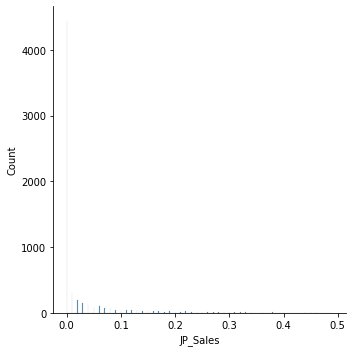

In [94]:
sns.displot(sm_deep_learning_df[sm_deep_learning_df["JP_Sales"]<.5]["JP_Sales"])

### This is suprising... in our data, the vast majority of games in Japan show 0 sales. 

### Given this, we will need to omit Japan from our analysis all together.

### We will try to get a good prediction on at least some of the Sales regions


### We will omit all user_score data since our unsupervised learning showed it was less useful than metascore. 

### Any info we could pick up from userscore is likely better encapsulated by metascore.




In [95]:
X = sm_deep_learning_df.drop(["NA_Sales", "JP_Sales","Global_Sales","Other_Sales","EU_Sales","user_score","positive_users","neutral_users","negative_users"],axis=1).values
y = sm_deep_learning_df[["NA_Sales","EU_Sales","Other_Sales","Global_Sales"]].values

### These neural networks arent working likely because the sales ranges are too spread out. 6000 out of our nearly 9000 games sold only between 0 and .25. The standard deviations are always several times the means of the mean sales of the games themselves. Worded differently, there are too many outliers in the dataset.


In [96]:
sm_deep_learning_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
NA_Sales,6467.0,0.436391,0.854377,0.00,0.09,0.19,0.45,15.85
EU_Sales,6467.0,0.247810,0.599914,0.00,0.02,0.07,0.23,12.88
JP_Sales,6467.0,0.067552,0.282949,0.00,0.00,0.00,0.02,6.50
Other_Sales,6467.0,0.091486,0.260648,0.00,0.01,0.03,0.08,10.57
Global_Sales,6467.0,0.843269,1.733725,0.01,0.17,0.37,0.84,35.82
...,...,...,...,...,...,...,...,...
month_11,6467.0,0.189887,0.392242,0.00,0.00,0.00,0.00,1.00
month_12,6467.0,0.041441,0.199324,0.00,0.00,0.00,0.00,1.00
is_handheld_1,6467.0,0.213236,0.409625,0.00,0.00,0.00,0.00,1.00
is_deprecated_yes,6467.0,0.957167,0.202496,0.00,1.00,1.00,1.00,1.00


In [101]:
# Train a new model off of the new data subset
meta_model = DeepLearning(X,y,"multi", drop="JP", input_dim=79, hidden_layers=4, output_shape=4)
meta_model.make_model()
meta_model.compile_model()
meta_model.fit_model()
meta_model.evaluate_model()

Epoch 1/600
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
107/142 [=====================>........] - ETA: 0s - loss: 0.9359 - mse: 0.9359WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe92f04dc20> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and at

### This shows an improvement over the previous model, as the MAE is now at least smaller than the mean itself

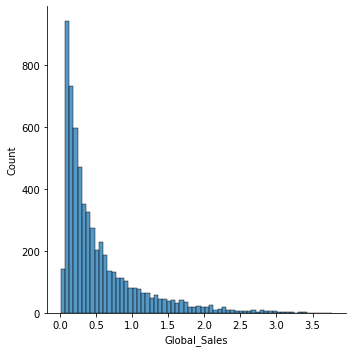

In [102]:
# Lets create an even smaller subsection of the data that 
# doesn't include outliers on the high end of each category of sales

# Culling all regions of their extreme outliers in Sales. Will use
# the resulting subsection of the data for modeling.
culled_network = sm_deep_learning_df[sm_deep_learning_df["Global_Sales"]<5]
culled_network = culled_network[culled_network["EU_Sales"]<1.5]
culled_network = culled_network[culled_network["Other_Sales"]<1.5]
culled_network = culled_network[culled_network["NA_Sales"]<1.5]


sns.displot(data=culled_network, x="Global_Sales")

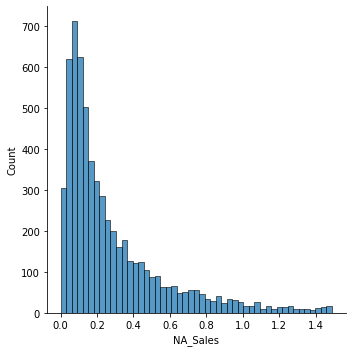

In [103]:
sns.displot(data=culled_network, x="NA_Sales")

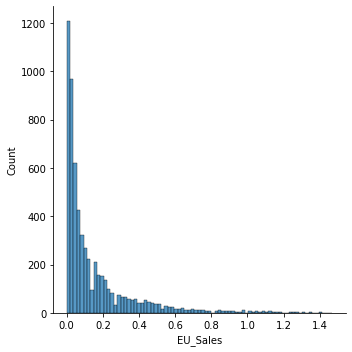

In [104]:
sns.displot(data=culled_network, x="EU_Sales")

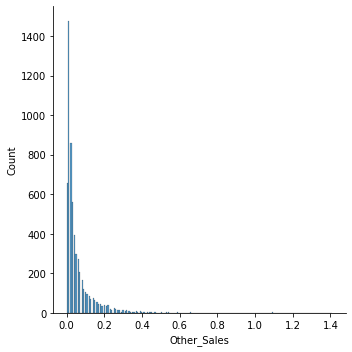

In [105]:
sns.displot(data=culled_network, x="Other_Sales")

In [106]:
# Lets see if we can accurately predict Sales now off of this dataset
# We will also be omitting all categories of user_scores.

X = culled_network.drop(["NA_Sales", "JP_Sales","Global_Sales","Other_Sales","EU_Sales", "user_score","positive_users","neutral_users","negative_users"],axis=1).values
y = culled_network[["NA_Sales","Global_Sales","Other_Sales","EU_Sales"]].values


In [107]:
X.shape

(6055, 79)

In [109]:
culled_model = DeepLearning(X,y,"multi", drop="JP",input_dim=79, hidden_layers=4,output_shape=4)
culled_model.make_model()
culled_model.compile_model()
culled_model.fit_model()
culled_model.evaluate_model()

Epoch 1/600
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
107/133 [=======================>......] - ETA: 0s - loss: 0.1437 - mse: 0.1437WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe92f3dfdd0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and at

### The errors are further down now, but still far from accurate
### Furthermore, these results are misleading because the mean of 
### NA_Sales has itself dropped to .283 million copies.


<hr>


### The games in our list have Sales that vary too drastically with an extreme right-skew. This makes our model unreliable at predicting accurately across our range of sales for games.

### Japan Sales data is so heavily clustered around 0 that it is unusable.

### We should move forward by attempting to predict sales for one region only, NA_Sales

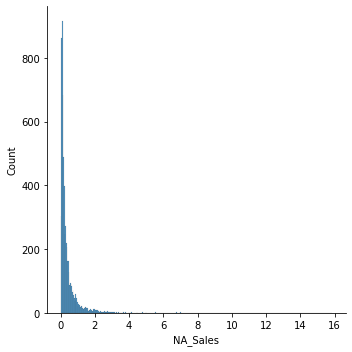

In [110]:
sns.displot(data=deep_learning_df, x="NA_Sales")

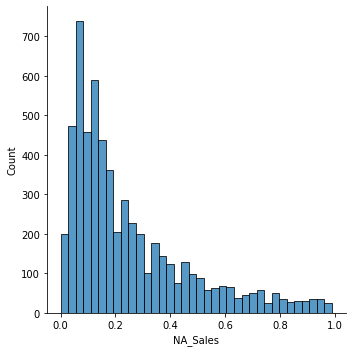

In [111]:
# Our dataset is small for a deep learning network, but it will have to do. Lets see if it predicts better!
deep_learning_df2 = deep_learning_df[deep_learning_df["NA_Sales"]<1]
# Sales in NA havs been culled of its extreme outliers. 
# We will add back in all categories of user reviews. (All features in use)
sns.displot(data=deep_learning_df2, x="NA_Sales")

In [112]:
X = deep_learning_df.drop(columns=["NA_Sales","EU_Sales","JP_Sales","Other_Sales","Global_Sales"]).values
y = deep_learning_df["NA_Sales"].values

In [113]:
NA_Sales_Model = DeepLearning(X,y,"not-multi", input_dim=83, hidden_layers=5, output_shape=1)

In [114]:
NA_Sales_Model.make_model()
NA_Sales_Model.compile_model()
NA_Sales_Model.fit_model()
NA_Sales_Model.evaluate_model()

Epoch 1/600
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
101/142 [====================>.........] - ETA: 0s - loss: 0.7198 - mse: 0.7198 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe92cb6e560> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and a

### This is one of the better outcomes.

### We will attempt to get rid of noisy columns athat are throwing off the model without adding anything of value. This is difficult because the point of the project was to test the limits of what a neural network can pick up. It is a given that with the features we chose they are all only loosely correlated with sales if at all. We dont have any columns that are sure to be strongly correlated with sales for the most part. It was the hope of the group that when looking at the features as a whole, the model would pick up subtle correlations between the seemingly poor predictors of Sales that would allow it to predict well. These features have proven to not be enough. 

In [115]:
combo_df.columns

Index(['Name', 'Platform', 'Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales',
       'Other_Sales', 'Global_Sales', 'metascore', 'user_score',
       'release_date', 'positive_critics', 'neutral_critics',
       'negative_critics', 'positive_users', 'neutral_users', 'negative_users',
       'number_players', 'rating', 'is_handheld', 'is_deprecated', 'is_retro',
       'year', 'month'],
      dtype='object')

### Since Sales represents the number of copies sold throughout the entire period they have been on the market, 
### The month they were released likely does not matter so much despite games tending to sell more when released
### around November. Conversely, the longer a game is in the market, the more time it has to rack up sales, so we 
### will leave in the year feature.

### release date and name will be dropped like before since we are using the combo_df again.

### Is_deprecated and is_retro are likely just noise and will be dropped. Number_players is likely not offering, anything particular to the model. 

### Platform will be dropped because some of these platforms are far less popular than others which could be throwing off the model. I do not want the model getting lazy and predicting purely off of platform.

### I will drop all sales except for NA_Sales. If we can get a model predicting accurately on one subsection, then we can try to expand to a model that will predict accurately for all of them. We must walk before we run.


In [116]:
minimalist_df = combo_df.drop(columns=["Name","release_date","month", "is_deprecated","is_retro","number_players", "Platform", "EU_Sales",\
                      "JP_Sales","Other_Sales","Global_Sales"])

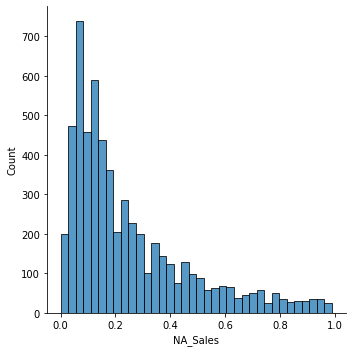

In [117]:
# We must again get rid of the outlier labels of the NA_Sales column
minimalist_culled = minimalist_df[minimalist_df["NA_Sales"]<1]

sns.displot(data= minimalist_culled, x="NA_Sales")

In [118]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)

encode_df = pd.DataFrame(enc.fit_transform(minimalist_culled[["Genre","rating","year"]].values))
encode_df.columns = enc.get_feature_names(["Genre","rating","year"])
encode_df.head()

,Genre_0,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7,Genre_8,Genre_9,...,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
encode_df2 = pd.DataFrame(enc.fit_transform(minimalist_culled.is_handheld.values.reshape(-1,1)))
encode_df2.columns= enc.get_feature_names(["is_handheld"])
encode_df2.head()

,is_handheld_0,is_handheld_1
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0


In [120]:
minimalist_culled = minimalist_culled.merge(encode_df,left_index=True, right_index=True).drop(["Genre","rating","year"],1)

In [121]:
minimalist_culled = minimalist_culled.merge(encode_df2, left_index=True, right_index=True).drop("is_handheld",1)

In [122]:
minimalist_culled.drop("is_handheld_0",1, inplace=True)

In [123]:
X = minimalist_culled.drop("NA_Sales",axis=1).values
y = minimalist_culled["NA_Sales"].values

In [133]:
# Increasing the number of units as well as the number of hidden_layers
minimalist_model = DeepLearning(X,y,"not-multi", input_dim=25, units=200, hidden_layers=4, output_shape=1)
minimalist_model.make_model()
minimalist_model.compile_model()
minimalist_model.fit_model()
minimalist_model.evaluate_model()

Epoch 1/600
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
101/116 [=========================>....] - ETA: 0s - loss: 0.0499 - mse: 0.0499WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe9333c6e60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and at

### Not great
### Lets try one more thing.

In [125]:
### repeat previous steps but with a different subsection of features.

minimalist_culled = minimalist_df[minimalist_df["NA_Sales"]<1]
minimalist_culled.drop("year",axis=1,inplace=True)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)

encode_df = pd.DataFrame(enc.fit_transform(minimalist_culled[["Genre","rating"]].values))
encode_df.columns = enc.get_feature_names(["Genre","rating"])
encode_df.head()

encode_df2 = pd.DataFrame(enc.fit_transform(minimalist_culled.is_handheld.values.reshape(-1,1)))
encode_df2.columns= enc.get_feature_names(["is_handheld"])
encode_df2.head()

minimalist_culled = minimalist_culled.merge(encode_df,left_index=True, right_index=True).drop(["Genre","rating"],1)
minimalist_culled = minimalist_culled.merge(encode_df2, left_index=True, right_index=True).drop("is_handheld",1)
minimalist_culled.drop("is_handheld_0",1, inplace=True)

X = minimalist_culled.drop("NA_Sales",axis=1).values
y = minimalist_culled["NA_Sales"].values

minimalist_model2 = DeepLearning(X,y,"not-multi", input_dim=25, output_shape=1)
minimalist_model2.make_model()
minimalist_model2.compile_model()
minimalist_model2.fit_model()
minimalist_model2.evaluate_model()

Epoch 1/600
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



114/116 [============================>.] - ETA: 0s - loss: 0.0616 - mse: 0.0616WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe931bffb90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
116/116 [==============================] - 1s 3ms/step - loss: 0.0614 - mse: 0.0614 - val_loss: 0.0420 - val_mse: 0.0420
Epoch 2/600
116/116 [========

## It looks like this is as low as I am going to get it. 
## The model is ultimately limited by the data itself and the features that are available to us. They are not capable of fully encapsulating all the variance we see in sales.